ref: https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms

Ref: https://women.trueid.net/detail/kEN97vDvokbn?utm_source=web-trueid&utm_medium=ctw&utm_term=clicklink&utm_campaign=women_4RQeYK5bOmMR_relatecontent_women_kEN97vDvokbn_15/02/2021

## Install Dependency

In [3]:
!pip install pythainlp==3.0.5
# !wget https://github.com/kokkoks/thai-joke-sentence-generator/blob/main/siaw_caption.txt .
!curl 'https://raw.githubusercontent.com/kokkoks/thai-joke-sentence-generator/main/siaw_caption.txt' > siaw_caption.txt

     |████████████████████████████████| 11.5 MB 12.3 MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39377  100 39377    0     0  31226      0  0:00:01  0:00:01 --:--:-- 31202


In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras
import tensorflow as tf
tf.random.set_seed(1234)
from numpy.random import seed
# set_random_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")

from pythainlp import word_tokenize
pd.set_option("max_colwidth", -1)

In [5]:
df = pd.read_csv("siaw_caption.txt", names=["text"])

In [6]:
df.head()

,text
0,รักของเราอาจไม่หวาน แต่คุณไม่ต้องหารกับใครนะ
1,ถ้าเธอยังไม่เข้านอน ลองเข้ามาในใจเราก่อนได้นะ
2,อยากให้เธอกินคลีนจัง เธอจะได้ลดของมัน แล้วมาเป็นของเรา
3,หลงตัวเองนิดหน่อย แต่ที่หลงบ่อยๆ ก็เธอนั่นแหละ
4,ชอบตื่นเช้าอ่ะ เพราะไม่อยากรักเธอในวันที่สายเกินไป


## Tokenize thai sentence

In [7]:
df["tokens"] = df["text"].apply(lambda text: word_tokenize(text, keep_whitespace=True))

In [8]:
df["processed_tokens"] = df["tokens"].apply(lambda tokens: tokens + ["END"])
df["processed_sentence"] = df["processed_tokens"].apply(lambda tokens: " ".join(tokens))

In [9]:
df[["processed_sentence"]]

,processed_sentence
0,รัก ของ เรา อาจ ไม่ หวาน แต่ คุณ ไม่ต้อง หาร กับ ใคร นะ END
1,ถ้า เธอ ยัง ไม่ เข้านอน ลอง เข้ามา ใน ใจ เรา ก่อน ได้ นะ END
2,อยาก ให้ เธอ กิน คลี น จัง เธอ จะ ได้ ลด ของ มัน แล้ว มา เป็น ของ เรา END
3,หลงตัวเอง นิดหน่อย แต่ ที่ หลง บ่อยๆ ก็ เธอ นั่นแหละ END
4,ชอบ ตื่น เช้า อ่ะ เพราะ ไม่ อยาก รัก เธอ ใน วันที่ สาย เกินไป END
...,...
295,ใคร มัน จะ อยู่ ข้าง เรา ได้ดี เท่า เงา ของ ตัวเรา เอง END
296,โสด สวย สต รอง ถ้า เธอ ได้ มอง แล้ วจะ เสียดาย END
297,โสด แล้ว ยิ้ม ดีกว่า ถูก ทิ้ง แล้ว ร้องไห้ END
298,เป็นโสด อย่าง อิสระ ดีกว่า เข้าไป เป็น ภาระ หัวใจ ใคร END


In [10]:
tokenizer = Tokenizer(lower=False)

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(df["processed_sentence"])

In [11]:
tokenizer.sequences_to_texts(inp_sequences[:10])

['รัก ของ',
 'รัก ของ เรา',
 'รัก ของ เรา อาจ',
 'รัก ของ เรา อาจ ไม่',
 'รัก ของ เรา อาจ ไม่ หวาน',
 'รัก ของ เรา อาจ ไม่ หวาน แต่',
 'รัก ของ เรา อาจ ไม่ หวาน แต่ คุณ',
 'รัก ของ เรา อาจ ไม่ หวาน แต่ คุณ ไม่ต้อง',
 'รัก ของ เรา อาจ ไม่ หวาน แต่ คุณ ไม่ต้อง หาร',
 'รัก ของ เรา อาจ ไม่ หวาน แต่ คุณ ไม่ต้อง หาร กับ']

In [12]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences[:,:-1]
    label = input_sequences[:,-1]
    label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [13]:
print(f"max_sequence_len: {max_sequence_len}, total_words: {total_words}")

max_sequence_len: 22, total_words: 897


## Define structure and train model.

In [14]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, output_dim=128, input_length=input_len))
    
    # model.add(LSTM(100))
    # model.add(Dropout(0.1))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 128)           114816    
                                                                 
 lstm (LSTM)                 (None, 21, 256)           394240    
                                                                 
 dropout (Dropout)           (None, 21, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 21, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 21, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

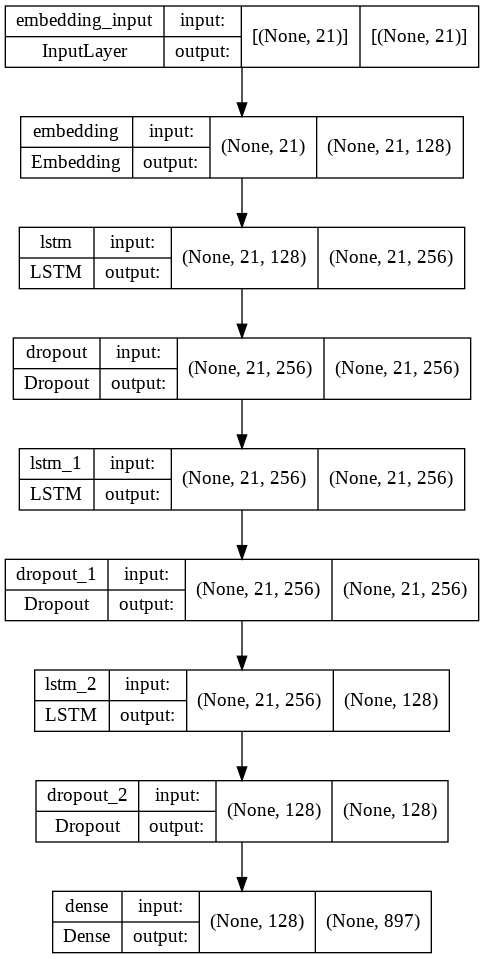

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.fit(predictors, label, epochs=500, verbose=1, callbacks=[early_stopping])

Epoch 1/500
112/112 [==============================] - 13s 32ms/step - loss: 5.8924
Epoch 2/500
112/112 [==============================] - 3s 31ms/step - loss: 5.5701
Epoch 3/500
112/112 [==============================] - 3s 31ms/step - loss: 5.5461
Epoch 4/500
112/112 [==============================] - 4s 32ms/step - loss: 5.5274
Epoch 5/500
112/112 [==============================] - 4s 33ms/step - loss: 5.4884
Epoch 6/500
112/112 [==============================] - 4s 35ms/step - loss: 5.3982
Epoch 7/500
112/112 [==============================] - 4s 36ms/step - loss: 5.3610
Epoch 8/500
112/112 [==============================] - 3s 31ms/step - loss: 5.3049
Epoch 9/500
112/112 [==============================] - 3s 30ms/step - loss: 5.2638
Epoch 10/500
112/112 [==============================] - 3s 30ms/step - loss: 5.1984
Epoch 11/500
112/112 [==============================] - 3s 31ms/step - loss: 5.1434
Epoch 12/500
112/112 [==============================] - 3s 31ms/step - loss: 5.0850


In [52]:
def generate_text(text, model, max_sequence_len):
    seed_text = " ".join(word_tokenize(text))
    counter = 0
    while counter < 100:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.random.choice(np.arange(0, predicted.shape[1]), p=predicted[0])

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
        if output_word == "END":
          joined_text = "".join(seed_text.split(" ")[:-1])
          return joined_text
        counter += 1
    return seed_text

In [53]:
test_text = "ถ้าเธอยังว่าง"
print(generate_text(test_text, model, max_sequence_len))

ถ้าเธอยังว่างว่างขอเนื้อย่างก่อนได้ป่าว


In [54]:
test_text = "ไม่รู้ไม่รู้ไม่รู้"
print(generate_text(test_text, model, max_sequence_len))

ไม่รู้ไม่รู้ไม่รู้จะไม่ติดมีมันๆเป็นมีเรา


## Save Model and Tokenizer

In [57]:
import pickle

model.save("model.h5")
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
test_model = tf.keras.models.load_model('model.h5')
with open('tokenizer.pickle', 'rb') as handle:
    test_tokenizer = pickle.load(handle)

In [59]:
def generate_text(text, model, max_sequence_len):
    seed_text = " ".join(word_tokenize(text))
    counter = 0
    while counter < 100:
        token_list = test_tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.random.choice(np.arange(0, predicted.shape[1]), p=predicted[0])

        output_word = ""
        for word, index in test_tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
        if output_word == "END":
          joined_text = "".join(seed_text.split(" ")[:-1])
          return joined_text
        counter += 1
    return seed_text

In [60]:
print(generate_text(test_text, test_model, max_sequence_len))

ไม่รู้ไม่รู้ไม่รู้ยังไม่ละลายเราคงต้องเปิดขวดน้ำมันพรายแล้วแหละ
